In [171]:
import os
import gc

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import numpy.ma as ma

from hbmep.config import Config
from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from models import NonHierarchicalBayesianModel
from constants import (
    DATA_PATH,
    TOML_PATH
)

In [172]:
src = "/home/andres/parameters_and_response.pkl"
with open(src, 'rb') as f:
    x, a, b, L, ell, H, y, subjects, configuration, electrodes, muscles = pickle.load(f)


EOFError: Ran out of input

In [ ]:
df = pd.read_csv("/home/andres/data/hbmep-processed/L_CIRC/data.csv")
config = Config(toml_path=TOML_PATH)
model = NonHierarchicalBayesianModel(config=config)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [ ]:
combination = pickle.load(open("/home/andres/repos/rat-mapping-paper/reports/L_CIRC/combine.pkl", "rb"))

In [ ]:
subjects = sorted(df['participant'].unique())
configuration = ['Vertex', 'Radius', 'Diameter']
electrodes = sorted(df['compound_position'].unique())
muscles = model.response

In [ ]:
vertices = [e for e in electrodes if e.split('-')[0] == '']

radii = [e for e in electrodes if e.split('-')[1] == 'C6LC' and e != '-C6LC']

diameters = set(electrodes) - (set(vertices) | set(radii))
diameters = list(diameters)


In [ ]:
def curve_parameters(
    named_param=None
):
    arr = []
    mask = []

    for sub in subjects:
        for config in configuration:
            for elec in electrodes:
                for m in muscles:
                    flag = False

                    if config == 'Vertex' and elec in vertices:
                        flag = True
                    elif config == 'Radius' and elec in radii:
                        flag = True
                    elif config == 'Diameter' and elec in diameters:
                        flag = True
                    else:
                        flag = False
                    
                    if flag:
                        position = elec
                        key = (sub, position, m)
                        tcomb = combination[key][named_param]
                        tcomb = tcomb.reshape(-1, 1)

                        arr.append(tcomb)
                        mask.append(np.full((4000,1), False))

                    else:
                        arr.append(np.zeros(4000).reshape(-1, 1))
                        mask.append(np.full((4000, 1), True))     

    param = np.array(arr)
    param = param.reshape(len(subjects), len(configuration),len(electrodes), len(muscles), *param.shape[1:])
    mask = np.array(mask)
    mask = mask.reshape(len(subjects), len(configuration),len(electrodes),len(muscles), *mask.shape[1:])

    param = ma.masked_array(param, mask=mask)
    param = param[..., 0]
    return param

In [ ]:
a = curve_parameters(site.a)
b = curve_parameters(site.b)
L = curve_parameters(site.L)
ell = curve_parameters(site.ell)
H = curve_parameters(site.H)

mask = a.mask


In [ ]:
x = np.arange(0, 500, .5)


In [ ]:
combination, df = None, None
del combination, df

gc.collect()

0

In [ ]:
y = F.rectified_logistic(
    x=x[None, None, None, None, None, :],
    a=a[..., None].filled(fill_value=-1),
    b=b[..., None].filled(fill_value=-1),
    L=L[..., None].filled(fill_value=-1),
    ell=ell[..., None].filled(fill_value=-1),
    H=H[..., None].filled(fill_value=-1)
)


In [ ]:
dest = "/home/andres/parameters_and_response.pkl"
with open(dest, 'wb') as f:
    pickle.dump((x, a, b, L, ell, H, y, subjects, configuration, electrodes, muscles), f)


In [ ]:
L.shape

(8, 3, 21, 6, 4000)

In [ ]:
arr.shape #subjects, combos, electrodes, muscles

(8, 3, 21, 6, 4000)

In [ ]:
[(i, e) for i, e in enumerate(electrodes) if e == "C6LE-C6LW"]

[(10, 'C6LE-C6LW')]

In [ ]:
a[5, 2, 10, :, :].mean(axis=-1)

masked_array(data=[388.8025597650362, 276.3106582041381,
                   334.9774591349229, 425.5215202602369,
                   244.1248570629337, 365.7248929129281],
             mask=[False, False, False, False, False, False],
       fill_value=1e+20)

In [ ]:
L[5, 2, 10, :, :].mean(axis=-1)

masked_array(data=[0.031088253814483515, 0.03191978019546997,
                   0.04949690888819987, 0.028254248838988402,
                   0.01799537732113529, 0.047990737410929185],
             mask=[False, False, False, False, False, False],
       fill_value=1e+20)

In [ ]:
a.shape

(8, 3, 21, 6, 4000)

In [ ]:
def get_pvalues(ind):
    pvalues = []
    mask = []
    data = []
    means =[]
    labels = []

    orientation_ind = ind
    if orientation_ind == 0:
        for l_electrode_ind, l_electrode in enumerate(electrodes):
            label = f"{l_electrode}"
            labels.append(label)
            for r_electrode_ind, r_electrode in enumerate(electrodes):
                if (l_electrode == r_electrode):
                    pvalues.append(1)
                    mask.append(True)
                    data.append(label)
                    means.append(0)
                    continue
                
                mask.append(False)

                l_samples = a[:, orientation_ind,l_electrode_ind,...]  # sub, seg, muscle, # posterior_samples
                r_samples = a[:, orientation_ind,r_electrode_ind,...] 
                
                t = l_samples.mean(axis=-1) - r_samples.mean(axis=-1)

                ttest = stats.ttest_1samp(
                    t, popmean=0, alternative="two-sided", axis=(0, 1)
                )

                pvalues.append(ttest.pvalue)
                ci = ttest.confidence_interval(.95)

                t = l_samples - r_samples # sub, seg, muscle, # posterior_samples
                data.append(
                    f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})"
                )
                means.append(t.mean())
        pvalues = np.array(pvalues)
        pvalues = pvalues.reshape(9, 9)

        mask = np.array(mask)
        mask = mask.reshape(9, 9)

        data = np.array(data)
        data = data.reshape(9, 9)

        means = np.array(means)
        means = means.reshape(9, 9)

                        
    if orientation_ind == 1: #radius 
        for l_electrode_ind, l_electrode in enumerate(electrodes):
            if l_electrode == 'C6LC':
                continue
            label = f"{l_electrode}-C6LC"
            labels.append(label)
            for r_electrode_ind, r_electrode in enumerate(electrodes):
                if r_electrode == 'C6LC':
                    continue
                if (l_electrode == r_electrode):
                    pvalues.append(1)
                    mask.append(True)
                    data.append(label)
                    means.append(0)
                    continue
                mask.append(False)

                l_samples = a[:, orientation_ind,l_electrode_ind,...]  # sub, seg, muscle, # posterior_samples
                r_samples = a[:, orientation_ind,r_electrode_ind,...] 
                
                t = l_samples.mean(axis=-1) - r_samples.mean(axis=-1)

                ttest = stats.ttest_1samp(
                    t, popmean=0, alternative="two-sided", axis=(0, 1)
                )

                pvalues.append(ttest.pvalue)
                ci = ttest.confidence_interval(.95)

                t = l_samples - r_samples # sub, seg, muscle, # posterior_samples
                data.append(
                    f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})"
                )
                means.append(t.mean())
        pvalues = np.array(pvalues)
        pvalues = pvalues.reshape(8, 8)

        mask = np.array(mask)
        mask = mask.reshape(8, 8)

        data = np.array(data)
        data = data.reshape(8, 8)

        means = np.array(means)
        means = means.reshape(8, 8)

        
    if orientation_ind == 2: #diameter 
        for l_electrode_ind, l_electrode in enumerate(electrodes):
            for r_electrode_ind, r_electrode in enumerate(electrodes):
                label = f"{l_electrode}"
                labels.append(label)
                if (l_electrode == r_electrode):
                    pvalues.append(1)
                    mask.append(True)
                    means.append(0)
                    data.append(1)
                    continue
                mask.append(False)

                l_samples = a[:, orientation_ind,l_electrode_ind,...]  # sub, seg, muscle, # posterior_samples
                r_samples = a[:, orientation_ind,r_electrode_ind,...] 
                
                t = l_samples.mean(axis=-1) - r_samples.mean(axis=-1)

                ttest = stats.ttest_1samp(
                    t, popmean=0, alternative="two-sided", axis=(0, 1)
                )

                pvalues.append(ttest.pvalue)
                ci = ttest.confidence_interval(.95)

                t = l_samples - r_samples # sub, seg, muscle, # posterior_samples
                data.append(
                    f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})"
                )
                means.append(t.mean())
        
        pvalues = np.array(pvalues)
        pvalues = pvalues.reshape(21, 21)

        mask = np.array(mask)
        mask = mask.reshape(21, 21)

        data = np.array(data)
        data = data.reshape(21, 21)

        means = np.array(means)
        means = means.reshape(21, 21)
    
    if (orientation_ind == 0) | (orientation_ind == 1): #vertex
        mask2= mask
        mask2 = np.tril(np.ones_like(mask2), k=-1)
        mask2 = mask2

        plt.figure(figsize=(15, 5))
        values = means
        handles = []
        cmap = 'coolwarm'
        ax=sns.heatmap(means, xticklabels=labels, yticklabels=labels, annot=data, fmt= "", mask =mask2,cbar = False,center = 0, cmap = "coolwarm")
        plt.xticks(rotation=45);
        hatch_mask = pvalues > 0.05

        for i in range (pvalues.shape[0]):
            for j in range(pvalues.shape[1]):
                if hatch_mask[i, j]:
                    ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
        handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                            hatch='', label="Significant"))
        handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                            hatch='////', label="Not Significant"))
        handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                            hatch='', label="Row Element Lower Threshold"))
        handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                            hatch='', label="Row Element Higher Threshold"))
        ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
                handlelength=2, handleheight=2, frameon=False)
        ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

        ax.yaxis.tick_right()
        plt.show()
    
    if orientation_ind == 2: 
        mask2= mask
        mask2 = np.tril(np.ones_like(mask2))
        mask2 = mask2

        plt.figure(figsize=(15, 5))
        handles = []
        ax=sns.heatmap(means, xticklabels=labels, yticklabels=labels, annot=data, fmt= "", mask =mask2,cbar = False,center = 0, cmap = "coolwarm")
        plt.xticks(rotation=45);
        hatch_mask = pvalues > 0.05

        for i in range (pvalues.shape[0]):
            for j in range(pvalues.shape[1]):
                if hatch_mask[i, j]:
                    ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
        handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                            hatch='', label="Significant"))
        handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                            hatch='////', label="Not Significant"))
        handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                            hatch='', label="Row Element Lower Threshold"))
        handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                            hatch='', label="Row Element Higher Threshold"))
        ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
                handlelength=2, handleheight=2, frameon=False)
        ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

        ax.yaxis.tick_right()
        plt.show()

/tmp/ipykernel_1917197/382242394.py:127: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})"
/tmp/ipykernel_1917197/382242394.py:140: UserWarning: Warning: converting a masked element to nan.
  means = np.array(means)


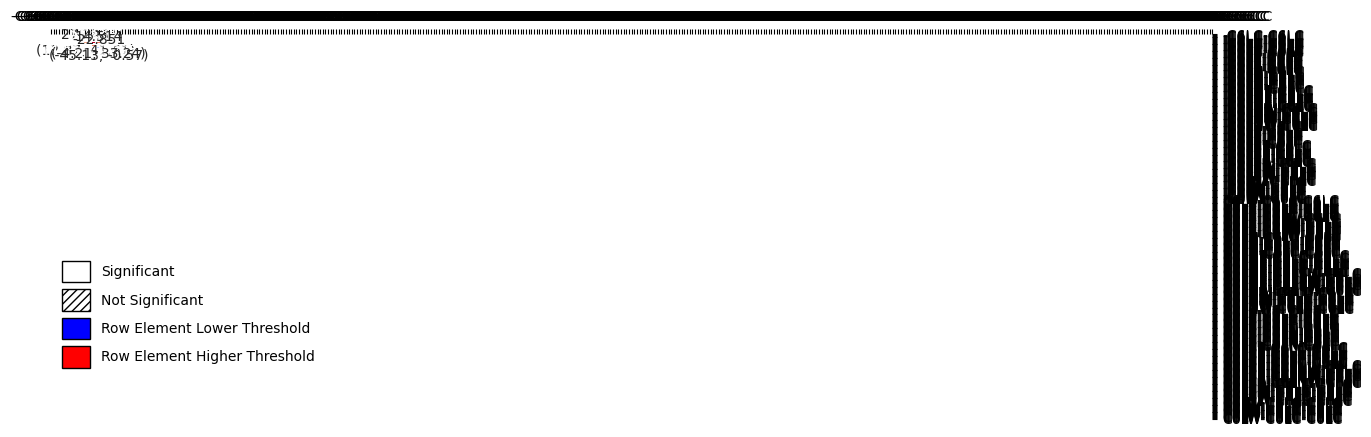

In [ ]:
get_pvalues(2)


In [ ]:
import math

In [ ]:
pvalues = []
mask = []
data = []
means =[]
labels = []

orientation_ind = 2

for l_electrode_ind, l_electrode in enumerate(electrodes):
    for r_electrode_ind, r_electrode in enumerate(electrodes):
        if (l_electrode == r_electrode):
            pvalues.append(1)
            mask.append(True)
            data.append(l_electrode)
            means.append(0)
            continue
        

        l_samples = a[:, orientation_ind,l_electrode_ind,...]  # sub, seg, muscle, # posterior_samples
        r_samples = a[:, orientation_ind,r_electrode_ind,...] 
        
        t = l_samples.mean(axis=-1) - r_samples.mean(axis=-1)

        ttest = stats.ttest_1samp(
            t, popmean=0, alternative="two-sided", axis=(0, 1)
        )

        pvalues.append(ttest.pvalue)
        ci = ttest.confidence_interval(.95)

        t = l_samples - r_samples # sub, seg, muscle, # posterior_samples
        data.append(
            f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})"
        )
        means.append(t.mean())
        
        if math.isnan(t.mean()):
            mask.append(True)

        else:
            mask.append(False)
            if l_electrode not in labels:
                label = f"{l_electrode}"
                labels.append(label)

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(21, 21)

mask = np.array(mask)
mask = mask.reshape(21, 21)

data = np.array(data)
data = data.reshape(21, 21)

means = np.array(means)
means = means.reshape(21, 21)

pvalues.shape

/home/andres/repos/rat-mapping-paper/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/andres/repos/rat-mapping-paper/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1917197/1663746785.py:33: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})"
/tmp/ipykernel_1917197/1663746785.py:37: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(t.mean()):
/tmp/ipykernel_1917197/1663746785.py:55: UserWarning: Warning: converting a masked element to nan.
  means = np.array(means)


(21, 21)

In [ ]:
labels

['C6LE-C6LW', 'C6LNE-C6LSW', 'C6LS-C6LN', 'C6LSE-C6LNW']

In [ ]:
import math

In [ ]:
for m, mean in enumerate(means):
    for i, ind in enumerate(mean):
        if math.isnan(mean[i]):
            mask[m][i] = 'True'

In [ ]:
math.isnan(mean[1])

True

In [ ]:
masked = ma.masked_array(means, mask = mask)

In [ ]:
masked = means[~mask]
masked.reshape()

In [ ]:
masked.shape

(12,)

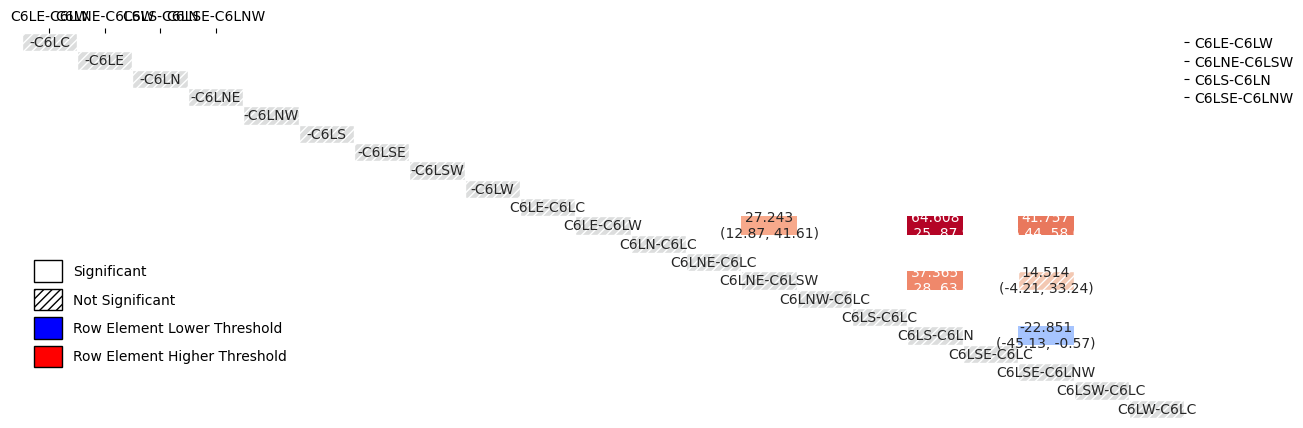

In [ ]:
mask2= mask
mask2 = np.tril(np.ones_like(mask2), k=-1)
mask2 = mask2

plt.figure(figsize=(15, 5))
values = means
handles = []
cmap = 'coolwarm'
ax=sns.heatmap(means, xticklabels=labels, yticklabels=labels, annot=data, fmt= "", mask =mask2,cbar = False,center = 0, cmap = "coolwarm")
plt.xticks(rotation=45);
hatch_mask = pvalues > 0.05

for i in range (pvalues.shape[0]):
  for j in range(pvalues.shape[1]):
      if hatch_mask[i, j]:
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='', label="Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='////', label="Not Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                    hatch='', label="Row Element Lower Threshold"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                    hatch='', label="Row Element Higher Threshold"))
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
          handlelength=2, handleheight=2, frameon=False)
ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

ax.yaxis.tick_right()
plt.show()

In [ ]:
mask2

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True